# **Mô hình KNN**

## **Import các thư viện cần thiết**

In [34]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## **Dữ liệu**

In [35]:
df = pd.read_csv("../data/data_processed/data_processed.csv")
df.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
0,120.0,0.0,0.0,0.0,0.0,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,4.0,0.0,4.0,2.0,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,2.0,0.0,5.0,2.0,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,2.0,0.0,6.0,2.0,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,4.0,0.0,5.0,0.0,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


## **Xây dựng mô hình KNN**

In [ ]:
# Các đặc trưng và nhãn
X = df.drop(columns=['NSP']).values 
y = df['NSP'].values  

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [37]:
# Hàm tính khoảng cách Euclidean
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

# Mô hình KNN
def knn(X_train, y_train, X_test, k):
    y_pred = []
    for test_point in X_test:
        distances = [euclidean_distance(test_point, train_point) for train_point in X_train]
        indices = np.argsort(distances)[:k]
        nearest_labels = [y_train[i] for i in indices]
        unique_values, counts = np.unique(nearest_labels, return_counts=True)
        y_pred.append(unique_values[np.argmax(counts)])
    return np.array(y_pred)

## **Triển khai KNN với nhiều tỷ lệ train/validation: 4:1; 7:3; 6:4**

### **Thực hiện với dữ liệu gốc**

In [38]:
test_sizes = [0.2, 0.3, 0.4]  
k_values = [3, 5, 7]  

results = []

for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    for k in k_values:
        y_pred = knn(X_train, y_train, X_test, k)
        acc = accuracy_score(y_test, y_pred)
        results.append({
            'Tỷ lệ Train/Test': f"{1-test_size:.1f}:{test_size:.1f}",
            'k': k,
            'Accuracy': acc
        })

# Chuyển kết quả thành DataFrame
results_df = pd.DataFrame(results)
print("Dữ liệu gốc:")
print(results_df.pivot(index='k', columns='Tỷ lệ Train/Test', values='Accuracy'))

Dữ liệu gốc:
Tỷ lệ Train/Test   0.6:0.4   0.7:0.3   0.8:0.2
k                                             
3                 0.883666  0.890282  0.892019
5                 0.882491  0.887147  0.887324
7                 0.871915  0.874608  0.884977


In [ ]:
# Tìm ra mô hình tốt nhất (có độ chính xác cao nhất)
best_model = results_df.loc[results_df['Accuracy'].idxmax()]

# Thông tin mô hình tốt nhất
best_k = best_model['k']
best_test_size = best_model['Tỷ lệ Train/Test']
print(f'Mô hình tốt nhất (dữ liệu gốc): k={best_k}, Tỷ lệ Train/Test={best_test_size}')
print(f"\nAccuracy (dữ liệu gốc): = {best_model["Accuracy"]}")

# Tìm lại dữ liệu tập huấn luyện và kiểm tra cho mô hình tốt nhất
test_size_dict = {'0.6:0.4': 0.4, '0.7:0.3': 0.3, '0.8:0.2': 0.2}
test_size = test_size_dict[best_test_size]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Huấn luyện và dự đoán với k tốt nhất
y_pred_best = knn(X_train, y_train, X_test, best_k)

print("\nClassification Report (dữ liệu gốc):")
print(classification_report(y_test, y_pred_best))

Mô hình tốt nhất (dữ liệu gốc): k=3, Tỷ lệ Train/Test=0.8:0.2

Accuracy (dữ liệu gốc): = 0.892018779342723

Classification Report (dữ liệu gốc):
              precision    recall  f1-score   support

         1.0       0.92      0.95      0.94       333
         2.0       0.71      0.64      0.67        64
         3.0       0.95      0.72      0.82        29

    accuracy                           0.89       426
   macro avg       0.86      0.77      0.81       426
weighted avg       0.89      0.89      0.89       426



In [40]:
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_best))

Confusion matrix:
[[318  14   1]
 [ 23  41   0]
 [  5   3  21]]


### **Giảm trước chia sau** (Tiềm ẩn Data leakage)

#### **Thực hiện với dữ liệu đã giảm chiều bằng PCA**

In [41]:
pca = PCA(n_components=6)
X_pca = pca.fit_transform(X)

test_sizes = [0.2, 0.3, 0.4]  
k_values = [3, 5, 7]  

results_pca = []

for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=test_size, random_state=42)
    
    for k in k_values:
        y_pred = knn(X_train, y_train, X_test, k)
        acc = accuracy_score(y_test, y_pred)
        results_pca.append({
            'Tỷ lệ Train/Test': f"{1-test_size:.1f}:{test_size:.1f}",
            'k': k,
            'Accuracy': acc
        })
        
# Chuyển kết quả thành DataFrame
results_df_pca = pd.DataFrame(results_pca)
print(results_df_pca.pivot(index='k', columns='Tỷ lệ Train/Test', values='Accuracy'))

Tỷ lệ Train/Test   0.6:0.4   0.7:0.3   0.8:0.2
k                                             
3                 0.882491  0.874608  0.877934
5                 0.874266  0.887147  0.889671
7                 0.874266  0.884013  0.884977


In [ ]:
# Tìm ra mô hình tốt nhất 
best_model = results_df_pca.loc[results_df_pca['Accuracy'].idxmax()]

# Thông tin mô hình tốt nhất
best_k = best_model['k']
best_test_size = best_model['Tỷ lệ Train/Test']
print(f'Mô hình tốt nhất (dữ liệu giảm chiều bằng PCA): k={best_k}, Tỷ lệ Train/Test={best_test_size}')
print(f"\nAccuracy (dữ liệu giảm chiều bằng PCA): = {best_model["Accuracy"]}")

# Tìm lại dữ liệu tập huấn luyện và kiểm tra cho mô hình tốt nhất
test_size_dict = {'0.6:0.4': 0.4, '0.7:0.3': 0.3, '0.8:0.2': 0.2}
test_size = test_size_dict[best_test_size]

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=test_size, random_state=42)

# Huấn luyện và dự đoán với k tốt nhất
y_pred_pca = knn(X_train_pca, y_train_pca, X_test_pca, best_k)

print("\nClassification Report (PCA):")
print(classification_report(y_test_pca, y_pred_pca))

Mô hình tốt nhất (dữ liệu giảm chiều bằng PCA): k=5, Tỷ lệ Train/Test=0.8:0.2

Accuracy (dữ liệu giảm chiều bằng PCA): = 0.8896713615023474

Classification Report (PCA):
              precision    recall  f1-score   support

         1.0       0.91      0.97      0.94       333
         2.0       0.72      0.53      0.61        64
         3.0       0.95      0.72      0.82        29

    accuracy                           0.89       426
   macro avg       0.86      0.74      0.79       426
weighted avg       0.88      0.89      0.88       426



In [43]:
print("Confusion matrix (PCA):")
print(confusion_matrix(y_test_pca, y_pred_pca))

Confusion matrix (PCA):
[[324   8   1]
 [ 30  34   0]
 [  3   5  21]]


#### **Thực hiện với dữ liệu đã giảm chiều bằng LDA**

In [44]:
lda = LDA(n_components=2)  
X_lda = lda.fit_transform(X, y)

test_sizes = [0.2, 0.3, 0.4]  
k_values = [3, 5, 7]  

results_lda = []

for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=test_size, random_state=42)
    
    for k in k_values:
        y_pred = knn(X_train, y_train, X_test, k)
        acc = accuracy_score(y_test, y_pred)
        results_lda.append({
            'Tỷ lệ Train/Test': f"{1-test_size:.1f}:{test_size:.1f}",
            'k': k,
            'Accuracy': acc
        })
        
# Chuyển kết quả thành DataFrame
results_df_lda = pd.DataFrame(results_pca)
print(results_df_lda.pivot(index='k', columns='Tỷ lệ Train/Test', values='Accuracy'))



Tỷ lệ Train/Test   0.6:0.4   0.7:0.3   0.8:0.2
k                                             
3                 0.882491  0.874608  0.877934
5                 0.874266  0.887147  0.889671
7                 0.874266  0.884013  0.884977


In [ ]:
# Tìm ra mô hình tốt nhất (có độ chính xác cao nhất)
best_model = results_df_lda.loc[results_df_lda['Accuracy'].idxmax()]

# Thông tin mô hình tốt nhất
best_k = best_model['k']
best_test_size = best_model['Tỷ lệ Train/Test']
print(f'Mô hình tốt nhất (dữ liệu giảm chiều bằng LDA): k={best_k}, Tỷ lệ Train/Test={best_test_size}')
print(f"\nAccuracy (dữ liệu giảm chiều bằng LDA): = {best_model["Accuracy"]}")

# Tìm lại dữ liệu tập huấn luyện và kiểm tra cho mô hình tốt nhất
test_size_dict = {'0.6:0.4': 0.4, '0.7:0.3': 0.3, '0.8:0.2': 0.2}
test_size = test_size_dict[best_test_size]

X_train_lda, X_test_lda, y_train_lda, y_test_lda = train_test_split(X_lda, y, test_size=test_size, random_state=42)

# Huấn luyện và dự đoán với k tốt nhất
y_pred_lda = knn(X_train_lda, y_train_lda, X_test_lda, best_k)

print("\nClassification Report (LDA):")
print(classification_report(y_test_lda, y_pred_lda))

Mô hình tốt nhất (dữ liệu giảm chiều bằng LDA): k=5, Tỷ lệ Train/Test=0.8:0.2

Accuracy (dữ liệu giảm chiều bằng LDA): = 0.8896713615023474

Classification Report (LDA):
              precision    recall  f1-score   support

         1.0       0.93      0.94      0.93       333
         2.0       0.63      0.59      0.61        64
         3.0       0.79      0.79      0.79        29

    accuracy                           0.88       426
   macro avg       0.79      0.78      0.78       426
weighted avg       0.88      0.88      0.88       426



In [46]:
print("Confusion matrix (LDA):")
print(confusion_matrix(y_test_lda, y_pred_best))

Confusion matrix (LDA):
[[318  14   1]
 [ 23  41   0]
 [  5   3  21]]


### **Chia trước giảm sau** 

#### **Thực hiện với dữ liệu đã giảm chiều bằng PCA**

In [47]:
test_sizes = [0.2, 0.3, 0.4]  
k_values = [3, 5, 7]  
n_components = 6
results_pca = []

for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)  

    for k in k_values:
        y_pred = knn(X_train_pca, y_train, X_test_pca, k)
        acc = accuracy_score(y_test, y_pred)
        results_pca.append({
            'Tỷ lệ Train/Test': f"{1-test_size:.1f}:{test_size:.1f}",
            'k': k,
            'Accuracy': acc
        })
        
# Chuyển kết quả thành DataFrame
results_df_pca = pd.DataFrame(results_pca)
print(results_df_pca.pivot(index='k', columns='Tỷ lệ Train/Test', values='Accuracy'))

Tỷ lệ Train/Test   0.6:0.4   0.7:0.3   0.8:0.2
k                                             
3                 0.877791  0.874608  0.880282
5                 0.878966  0.885580  0.889671
7                 0.871915  0.884013  0.877934


In [ ]:
# Tìm ra mô hình tốt nhất 
best_model = results_df_pca.loc[results_df_pca['Accuracy'].idxmax()]

# Thông tin mô hình tốt nhất
best_k = best_model['k']
best_test_size = best_model['Tỷ lệ Train/Test']
print(f'Mô hình tốt nhất (dữ liệu giảm chiều bằng PCA): k={best_k}, Tỷ lệ Train/Test={best_test_size}')
print(f"\nAccuracy (dữ liệu giảm chiều bằng PCA): = {best_model["Accuracy"]}")

# Tìm lại dữ liệu tập huấn luyện và kiểm tra cho mô hình tốt nhất
test_size_dict = {'0.6:0.4': 0.4, '0.7:0.3': 0.3, '0.8:0.2': 0.2}
test_size = test_size_dict[best_test_size]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)  

# Huấn luyện và dự đoán với k tốt nhất
y_pred_pca = knn(X_train_pca, y_train_pca, X_test_pca, best_k)

print("\nClassification Report (PCA):")
print(classification_report(y_test_pca, y_pred_pca)) 

Mô hình tốt nhất (dữ liệu giảm chiều bằng PCA): k=5, Tỷ lệ Train/Test=0.8:0.2

Accuracy (dữ liệu giảm chiều bằng PCA): = 0.8896713615023474

Classification Report (PCA):
              precision    recall  f1-score   support

         1.0       0.91      0.97      0.94       333
         2.0       0.72      0.53      0.61        64
         3.0       0.95      0.72      0.82        29

    accuracy                           0.89       426
   macro avg       0.86      0.74      0.79       426
weighted avg       0.88      0.89      0.88       426



In [49]:
print("Confusion matrix (PCA):")
print(confusion_matrix(y_test_pca, y_pred_pca))

Confusion matrix (PCA):
[[324   8   1]
 [ 30  34   0]
 [  3   5  21]]


#### **Thực hiện với dữ liệu đã giảm chiều bằng PCA**

In [51]:
test_sizes = [0.2, 0.3, 0.4]  
k_values = [3, 5, 7]  

results_lda = []
n_components_lda = 2

for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    lda = LDA(n_components=n_components_lda)
    X_train_lda = lda.fit_transform(X_train, y_train)
    X_test_pca = pca.transform(X_test)  
    X_test_lda = lda.transform(X_test)

    for k in k_values:
        y_pred = knn(X_train, y_train, X_test, k)
        acc = accuracy_score(y_test, y_pred)
        results_lda.append({
            'Tỷ lệ Train/Test': f"{1-test_size:.1f}:{test_size:.1f}",
            'k': k,
            'Accuracy': acc
        })
        
# Chuyển kết quả thành DataFrame
results_df_lda = pd.DataFrame(results_pca)
print(results_df_lda.pivot(index='k', columns='Tỷ lệ Train/Test', values='Accuracy'))



Tỷ lệ Train/Test   0.6:0.4   0.7:0.3   0.8:0.2
k                                             
3                 0.877791  0.874608  0.880282
5                 0.878966  0.885580  0.889671
7                 0.871915  0.884013  0.877934


In [52]:
# Tìm ra mô hình tốt nhất (có độ chính xác cao nhất)
best_model = results_df_lda.loc[results_df_lda['Accuracy'].idxmax()]

# Thông tin mô hình tốt nhất
best_k = best_model['k']
best_test_size = best_model['Tỷ lệ Train/Test']
print(f'Mô hình tốt nhất (dữ liệu giảm chiều bằng LDA): k={best_k}, Tỷ lệ Train/Test={best_test_size}')
print(f"\nAccuracy (dữ liệu giảm chiều bằng LDA): = {best_model["Accuracy"]}")

# Tìm lại dữ liệu tập huấn luyện và kiểm tra cho mô hình tốt nhất
test_size_dict = {'0.6:0.4': 0.4, '0.7:0.3': 0.3, '0.8:0.2': 0.2}
test_size = test_size_dict[best_test_size]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
lda = LDA(n_components=n_components_lda)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_pca = pca.transform(X_test)  
X_test_lda = lda.transform(X_test)

# Huấn luyện và dự đoán với k tốt nhất
y_pred_lda = knn(X_train_lda, y_train_lda, X_test_lda, best_k)

print("\nClassification Report (LDA):")
print(classification_report(y_test_lda, y_pred_lda))

Mô hình tốt nhất (dữ liệu giảm chiều bằng LDA): k=5, Tỷ lệ Train/Test=0.8:0.2

Accuracy (dữ liệu giảm chiều bằng LDA): = 0.8896713615023474

Classification Report (LDA):
              precision    recall  f1-score   support

         1.0       0.94      0.93      0.93       333
         2.0       0.62      0.61      0.61        64
         3.0       0.70      0.79      0.74        29

    accuracy                           0.87       426
   macro avg       0.75      0.78      0.76       426
weighted avg       0.87      0.87      0.87       426



In [53]:
print("Confusion matrix (LDA):")
print(confusion_matrix(y_test_lda, y_pred_best))

Confusion matrix (LDA):
[[318  14   1]
 [ 23  41   0]
 [  5   3  21]]


## Trực quan hóa và đánh giá tương quan giữa dự đoán – thực tế. 

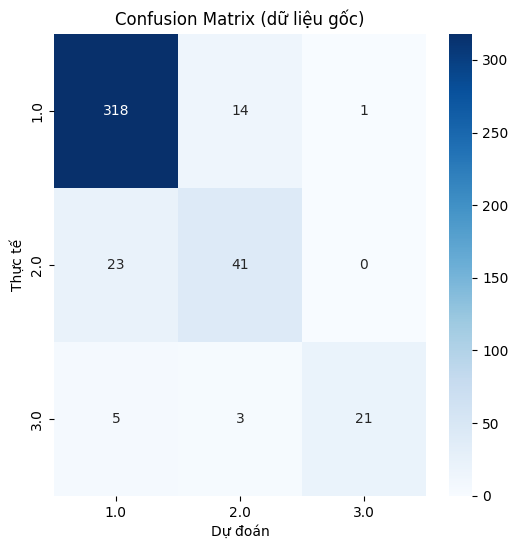

In [58]:
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_best, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix (dữ liệu gốc)")
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.show()


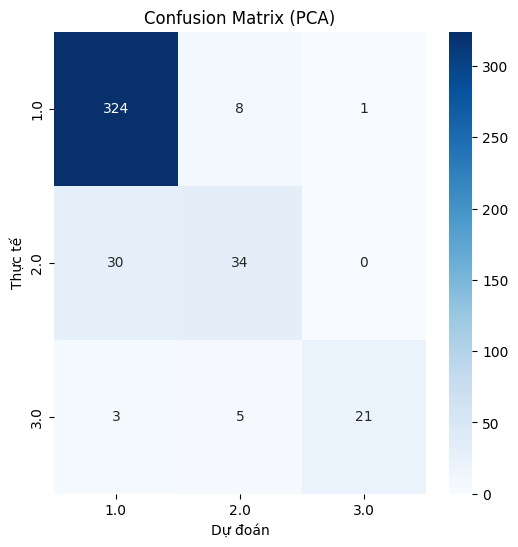

In [56]:
conf_matrix_pca = confusion_matrix(y_test_pca, y_pred_pca)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_pca, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix (PCA)")
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.show()

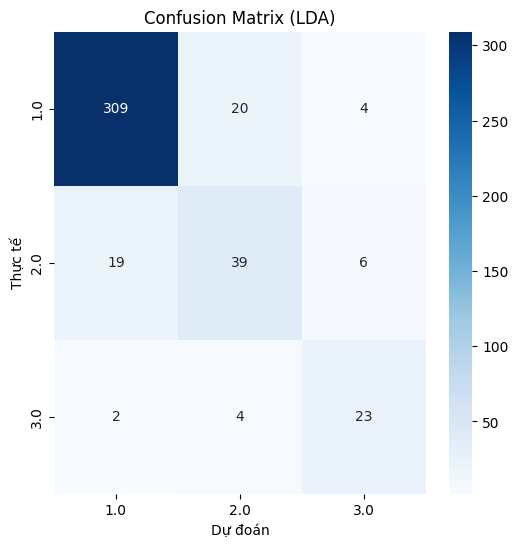

In [59]:
conf_matrix_lda = confusion_matrix(y_test_lda, y_pred_lda)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_lda, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix (LDA)")
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.show()
